<a href="https://colab.research.google.com/github/renweizhukov/jupyter-lab-notebook/blob/main/hugging-face-agents-course/mail_sorting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alfred the Mail Sorting Butler: A LangGraph Example

In this notebook, **we're going to build a complete email processing workflow using LangGraph**.

This notebook is part of the <a href="https://www.hf.co/learn/agents-course">Hugging Face Agents Course</a>, a free course from beginner to expert, where you learn to build Agents.

![Agents course share](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/communication/share.png)

## What You'll Learn

In this notebook, you'll learn how to:
1. Set up a LangGraph workflow
2. Define state and nodes for email processing
3. Create conditional branching in a graph
4. Connect an LLM for classification and content generation
5. Visualize the workflow graph
6. Execute the workflow with example data

In [1]:
# Install the required packages
%pip install -q langgraph langchain_openai langchain_huggingface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

## Setting Up Our Environment

First, let's import all the necessary libraries. LangGraph provides the graph structure, while LangChain offers convenient interfaces for working with LLMs.

In [2]:
import os
from google.colab import userdata
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage

# Set your OpenAI API key here
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")  # Replace with your actual API key

## Step 1: Define Our State

In LangGraph, **State** is the central concept. It represents all the information that flows through our workflow.

For Alfred's email processing system, we need to track:
- The email being processed
- Whether it's spam or not
- The draft response (for legitimate emails)
- Conversation history with the LLM

In [4]:
class EmailState(TypedDict):
    # The email being processed
    email: Dict[str, Any]  # Contains subject, sender, body, etc.

    # Category of the email (inquiry, complaint, etc.)
    email_category: Optional[str]

    # Reason why the email was marked as spam
    spam_reason: Optional[str]

    # Analysis and decisions
    is_spam: Optional[bool]

    # Response generation
    email_draft: Optional[str]

    # Processing metadata
    messages: List[Dict[str, Any]]  # Track conversation with LLM for analysis

## Step 2: Define Our Nodes

In [9]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint


# Initialize LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)


# Define nodes
def read_email(state: EmailState):
    email = state["email"]
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")
    return {}

def classify_email(state: EmailState):
    email = state["email"]

    prompt = f"""
    As Alfred the butler, analyze this email and determine if it is spam or legitimate.

    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}

    First, determine if this email is spam. If it is spam, explain why.
    If it is legitimate, categorize it (inquiry, complaint, thank you, etc.).
    """
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    # Simple logic to parse the response (in a real app, you'd want more robust parsing)
    response_text = response.content.lower()
    is_spam = "spam" in response_text and "not spam" not in response_text

    # Extract a reason if it's spam
    spam_reason = None
    if is_spam and "reason:" in response_text:
        spam_reason = response_text.split("reason:")[1].strip()

    # Determine category if legitimate
    email_category = None
    if not is_spam:
        categories = ["inquiry", "complaint", "thank you", "request", "information"]
        for category in categories:
            if category in response_text:
                email_category = category
                break

    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]

    # Return state updates
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
        "messages": new_messages
    }

def handle_spam(state: EmailState):
    """Alfred discards spam email with a note"""
    print(f"Alfred has marked the email as spam. Reason: {state['spam_reason']}")
    print("The email has been moved to the spam folder.")

    return {}

def draft_response(state: EmailState):
    email = state["email"]
    category = state["email_category"] or "general"

    prompt = f"""
    As Alfred the butler, draft a polite preliminary response to this email.

    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}

    This email has been categorized as: {category}

    Draft a brief, professional response that Mr. Hugg can review and personalize before sending.
    """

    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]

    return {
        "email_draft": response.content,
        "messages": new_messages
    }

def notify_mr_hugg(state: EmailState):
    """Alfred notifies Mr. Hugg about the email and presents the draft response"""
    email = state["email"]

    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print(f"Category: {state['email_category']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["email_draft"])
    print("="*50 + "\n")

    return {}

# Define routing logic
def route_email(state: EmailState) -> str:
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email) # the read_email node executes the read_mail function
email_graph.add_node("classify_email", classify_email) # the classify_email node will execute the classify_email function
email_graph.add_node("handle_spam", handle_spam) #same logic
email_graph.add_node("draft_response", draft_response) #same logic
email_graph.add_node("notify_mr_hugg", notify_mr_hugg) # same logic


## Step 3: Define Our Routing Logic

In [10]:
# Add edges
email_graph.add_edge(START, "read_email") # After starting we go to the "read_email" node

email_graph.add_edge("read_email", "classify_email") # after_reading we classify

# Add conditional edges
email_graph.add_conditional_edges(
    "classify_email", # after classify, we run the "route_email" function"
    route_email,
    {
        "spam": "handle_spam", # if it return "Spam", we go the "handle_span" node
        "legitimate": "draft_response" # and if it's legitimate, we go to the "drafting response" node
    }
)

# Add final edges
email_graph.add_edge("handle_spam", END) # after handling spam we always end
email_graph.add_edge("draft_response", "notify_mr_hugg")
email_graph.add_edge("notify_mr_hugg", END) # after notifyinf Me wayne, we can end  too


## Step 4: Create the StateGraph and Define Edges

In [11]:
# Compile the graph
compiled_graph = email_graph.compile()

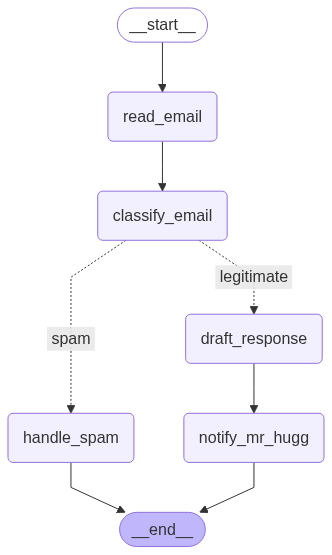

In [12]:
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

## Step 5: Run the Application

In [14]:
 # Example emails for testing
legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about your services",
    "body": "Dear Mr. Hugg, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}

spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}

# Process legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})

# Process spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Processing legitimate email...
Alfred is processing an email from john.smith@example.com with subject: Question about your services

Sir, you've received an email from john.smith@example.com.
Subject: Question about your services
Category: inquiry

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Question about our services

Dear Mr. Smith,

Thank you for reaching out and for your interest in our consulting services. We would be delighted to discuss how we can assist you. I will coordinate with Mr. Hugg to find a convenient time for a call next week. Please let us know your availability, and we will do our best to accommodate.

Best regards,

Alfred  
Assistant to Mr. Hugg


Processing spam email...
Alfred is processing an email from winner@lottery-intl.com with subject: YOU HAVE WON $5,000,000!!!
Alfred has marked the email as spam. Reason: None
The email has been moved to the spam folder.


## Step 6: Inspecting Our Mail Sorting Agent with Langfuse

In [19]:
%pip install -q langfuse

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.4/275.4 kB 17.8 MB/s eta 0:00:00


In [20]:
%pip install langchain

In [21]:
from google.colab import userdata
import os

# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = userdata.get('LANGFUSE_PUBLIC_KEY')
os.environ["LANGFUSE_SECRET_KEY"] = userdata.get('LANGFUSE_SECRET_KEY')
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com"

In [23]:
from langfuse.callback import CallbackHandler

# Initialize Langfuse CallbackHandler for LangGraph/Langchain (tracing)
langfuse_handler = CallbackHandler()

# Process legitimate email
legitimate_result = compiled_graph.invoke(
    input={"email": legitimate_email, "is_spam": None, "spam_reason": None, "email_category": None, "email_draft": None, "messages": []},
    config={"callbacks": [langfuse_handler]}
)

Alfred is processing an email from john.smith@example.com with subject: Question about your services

Sir, you've received an email from john.smith@example.com.
Subject: Question about your services
Category: inquiry

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Question about our services

Dear Mr. Smith,

Thank you for reaching out and for your interest in our consulting services. We would be delighted to discuss how we can assist you. I will coordinate with Mr. Hugg to find a suitable time for a call next week. Please let us know your availability, and we will do our best to accommodate.

Best regards,

Alfred  
Assistant to Mr. Hugg



In [24]:
spam_result = compiled_graph.invoke(
    input={
        "email": spam_email,
        "is_spam": None,
        "spam_reason": None,
        "email_category": None,
        "email_draft": None,
        "messages": []},
    config={"callbacks": [langfuse_handler]}
)

Alfred is processing an email from winner@lottery-intl.com with subject: YOU HAVE WON $5,000,000!!!
Alfred has marked the email as spam. Reason: None
The email has been moved to the spam folder.
